In [13]:
import os
import socket
import utils
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from utils import ext_transforms as et

DATA_DIR = {
    3 : "/mnt/server5/sdi/datasets",
    4 : "/mnt/server5/sdi/datasets",
    5 : "/data1/sdi/datasets"
}

def get_datadir():
    if socket.gethostname() == "server3":
        return DATA_DIR[3]
    elif socket.gethostname() == "server4":
        return DATA_DIR[4]
    elif socket.gethostname() == "server5":
        return DATA_DIR[5]
    else:
        raise NotImplementedError

In [157]:
import numbers
import torchvision.transforms.functional as F

class ExtGaussianRandomCrop(object):
    """Crop the given PIL Image at a gaussian dist based random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        pad_if_needed (boolean): It will pad the image if smaller than the
            desired size to avoid raising an exception.
    """

    def __init__(self, size, normal_h, normal_w, block_size, pad_if_needed=True):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.pad_if_needed = pad_if_needed
        self.normal_h = normal_h
        self.normal_w = normal_w
        self.block_size = block_size
        
    @staticmethod
    def get_params(idxw, idxh, output_size):
        """Get parameters for ``crop`` for a random crop.
        Args:
            output_size (tuple): Expected output size of the crop.
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
        """
        th, tw = output_size
        i = 0 if idxh - th/2 < 0 else int(idxh - th/2)
        j = 0 if idxw - tw/2 < 0 else int(idxw - tw/2)

        return i, j, th, tw
        
    @staticmethod
    def get_index(mu, sigma, block_size, verbose=True):
        x = np.random.normal(mu, sigma)
        x = np.random.randint(low=(np.rint(x) - 1)*block_size, high=np.rint(x)*block_size)
        if verbose:
            print(f'mu: {mu}, std: {sigma}, x:{x}')
        return x

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL Image): Image to be cropped.
            lbl (PIL Image): Label to be cropped.
        Returns:
            PIL Image: Cropped image.
            PIL Image: Cropped label.
        """
        assert img.size == lbl.size, 'size of img and lbl should be the same. %s, %s'%(img.size, lbl.size)

        idxw = self.get_index(mu=self.normal_w[0], sigma=self.normal_w[1], block_size=self.block_size)
        idxh = self.get_index(mu=self.normal_h[0], sigma=self.normal_h[1], block_size=self.block_size)

        # pad the width if needed
        if self.pad_if_needed and img.size[0] < self.size[1]:
            img = F.pad(img, padding=int((1 + self.size[1] - img.size[0]) / 2))
            lbl = F.pad(lbl, padding=int((1 + self.size[1] - lbl.size[0]) / 2))

        # pad the height if needed
        if self.pad_if_needed and img.size[1] < self.size[0]:
            img = F.pad(img, padding=int((1 + self.size[0] - img.size[1]) / 2))
            lbl = F.pad(lbl, padding=int((1 + self.size[0] - lbl.size[1]) / 2))

        i, j, h, w = self.get_params(idxw, idxh, self.size)

        return F.crop(img, i, j, h, w), F.crop(lbl, i, j, h, w)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0})'.format(self.size)

mu: 44.22, std: 12.01, x:359
mu: 21.08, std: 8.13, x:90


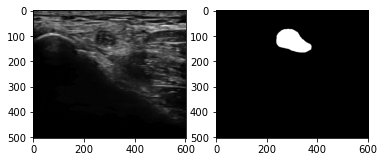

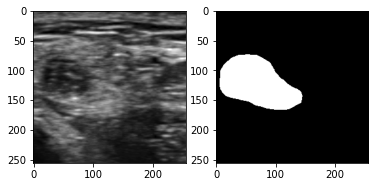

In [226]:
transform = ExtGaussianRandomCrop(size=(256, 256), normal_h=(21.08, 8.13), normal_w=(44.22, 12.01), block_size=5)
#scale = et.ExtScale(scale=0.8)

datadir = os.path.join(get_datadir(), 'CPN_all/Images')
maskdir = os.path.join(get_datadir(), 'CPN_all/Masks')
area = []

i = 0
for fname in os.listdir(datadir):
    i += 1
    if i > 7 :
        mname = fname.split('.')[0] + "_mask." + fname.split('.')[-1]
        mask = os.path.join(maskdir, mname)
        image = os.path.join('/data1/sdi/datasets/CPN_all/Images', fname)
        
        if not os.path.exists(mask) or not os.path.exists(image):
            raise Exception ("File Not Exists", mask, image)
        
        image = Image.open(image).convert("L")
        mask = Image.open(mask).convert("L")
        if False:
            plt.subplot(121)
            plt.imshow(image, cmap='gray')
            plt.subplot(122)
            plt.imshow(mask, cmap='gray')
            plt.show()
        #image, mask = scale(image, mask)
        im, lbl = transform(image, mask)
        if True:
            plt.subplot(121)
            plt.imshow(image, cmap='gray')
            plt.subplot(122)
            plt.imshow(mask, cmap='gray')
            plt.show()
            plt.subplot(121)
            plt.imshow(im, cmap='gray')
            plt.subplot(122)
            plt.imshow(lbl, cmap='gray')
            plt.show()
        break
    